## Summary notes

Use Holt-Winter's exponential smoothing method to model a seasonal time series with a trend.

Data was sourced from Rdatasets[^1] using StatsModels `Datasets` package.[^2]

We use StatsModels' `ExponentialSmoothing`[^3] class to model the time series.

Fitting the time series using the `ExponentialSmoothing.fit` method returns an instance of `HoltWinterResult`.[^5]

This topic is covered in M249, Book 2, Parts 2.7 & 2.9

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels import api as sm
from statsmodels.tsa import api as tsa
from statsmodels.graphics import tsaplots
from matplotlib import pyplot as plt
import seaborn as sns
import laughingrook as lr

Set the graphing defaults.
(This is optional.)

In [2]:
sns.set_theme()

## Main

### Load the data

In [3]:
electricity = lr.datasets.get_csv_file('m249/timeseries/electricity.csv')
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      300 non-null    object 
 1   demand    300 non-null    int64  
 2   sademand  300 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.2+ KB


### Initialise and plot the time series

The first observation is in January 1965.

In [4]:
electricity['date'].head(1)

0    Jan-1965
Name: date, dtype: object

Initialise the `Series`.

In [5]:
ts_demand = pd.Series(
    data=electricity['demand'].to_numpy(),
    name='demand',
    index=pd.date_range(
        start='1965-01',
        periods=electricity['demand'].size,
        freq='M',
        name='month'
    )
)
ts_demand.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 300 entries, 1965-01-31 to 1989-12-31
Freq: M
Series name: demand
Non-Null Count  Dtype
--------------  -----
300 non-null    int64
dtypes: int64(1)
memory usage: 4.7 KB


Plot the time series.

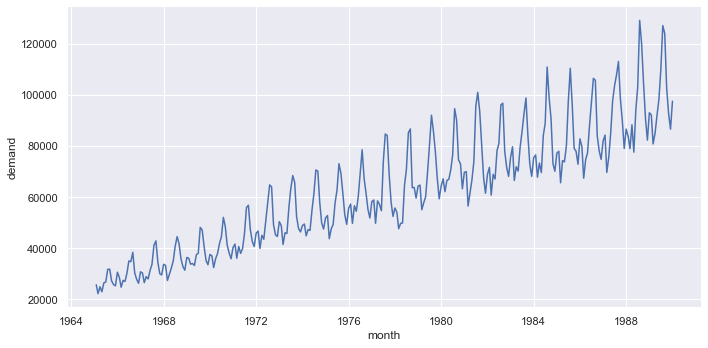

In [6]:
_g = sns.relplot(x=ts_demand.index, y=ts_demand, kind='line', aspect=2)
plt.show()

Transform time series.

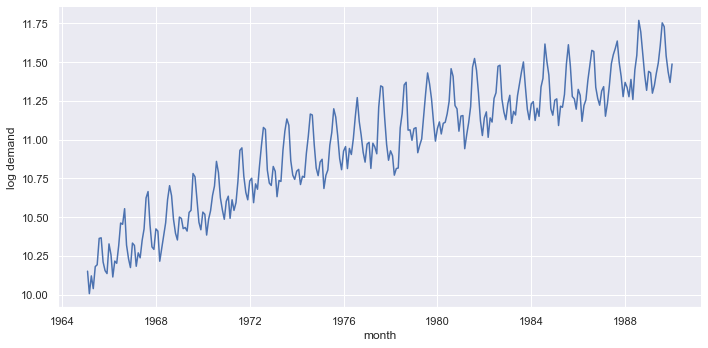

In [7]:
ts_logdemand = ts_demand.map(np.log).rename('log demand')
_g = sns.relplot(x=ts_logdemand.index, y=ts_logdemand, kind='line', aspect=2)
plt.show()

### Smooth the time series

Model and fit the time series.

In [8]:
holtwint = tsa.ExponentialSmoothing(
    ts_logdemand,
    trend="additive",
    seasonal="additive",
    initialization_method='estimated'
)
fitted = holtwint.fit()

Construct a `DataFrame` holding both the *observed* and *fitted* time series.

In [9]:
all_ts_logdemand = pd.merge(
    left=ts_logdemand.rename('obs'),
    right=fitted.fittedvalues.rename('fit'),
    left_index=True,
    right_index=True
)
all_ts_logdemand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 1965-01-31 to 1989-12-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   obs     300 non-null    float64
 1   fit     300 non-null    float64
dtypes: float64(2)
memory usage: 7.0 KB


Plot the observerved and fitted time series.

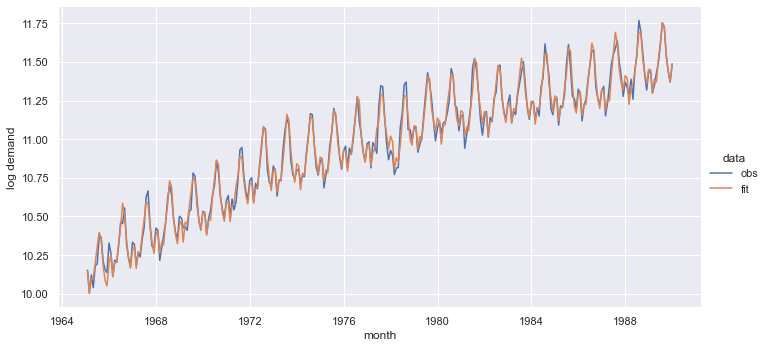

In [10]:
_gsource = all_ts_logdemand.melt(
    var_name='data',
    value_name='log demand',
    ignore_index=False
).reset_index()

g = sns.relplot(
            data=_gsource,
            x='month',
            y='log demand',
            hue='data',
            kind='line',
            aspect=2
)
plt.show()

Get the fitted model's parameters.

In [11]:
pd.Series(
    data={
        'alpha': fitted.params['smoothing_level'].round(5),
        'gamma': fitted.params['smoothing_trend'].round(5),
        'delta': fitted.params['smoothing_seasonal'].round(5),
        'sse': fitted.sse.round(5)
    },
    name='smoothing parameters'
)

alpha    0.41311
gamma    0.00000
delta    0.00000
sse      0.60365
Name: smoothing parameters, dtype: float64

### Check the model

Plot the forecasting errors.

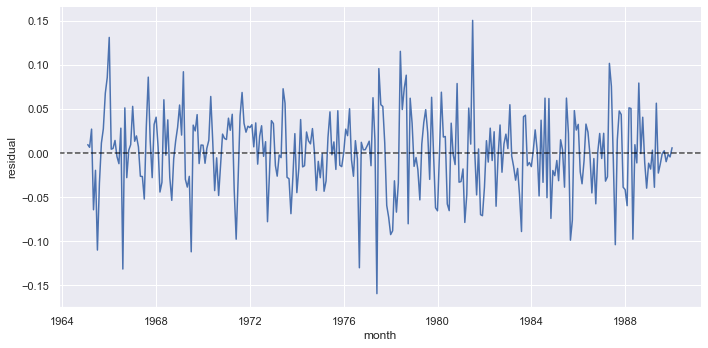

In [12]:
_g = sns.relplot(x=fitted.resid.index, y=fitted.resid, kind='line', aspect=2)
plt.axhline(0, alpha=0.7, ls='--', color='black')
plt.ylabel('residual')
plt.show()

Plot the in-sample autocorrelations.

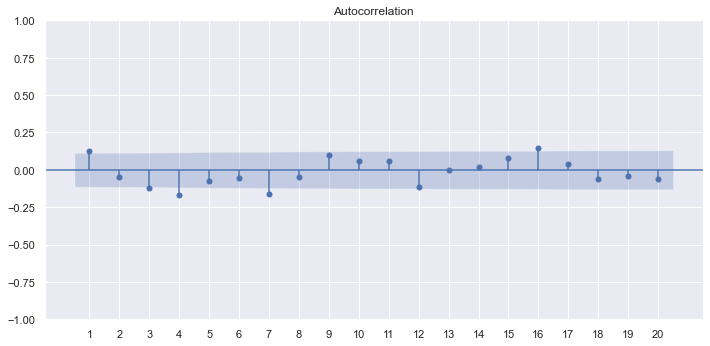

In [13]:
_f, _ax = plt.subplots(figsize=(11.8, 5.5))
tsaplots.plot_acf(fitted.resid, ax=_ax, lags=20, zero=False)
plt.xticks(range(1, 21))
plt.show()

Return the results of a Ljung-Box test.

In [14]:
sm.stats.acorr_ljungbox(fitted.resid, lags=[20])

,lb_stat,lb_pvalue
20,52.392304,0.0001


Plot a histogram of the forecasting errors.

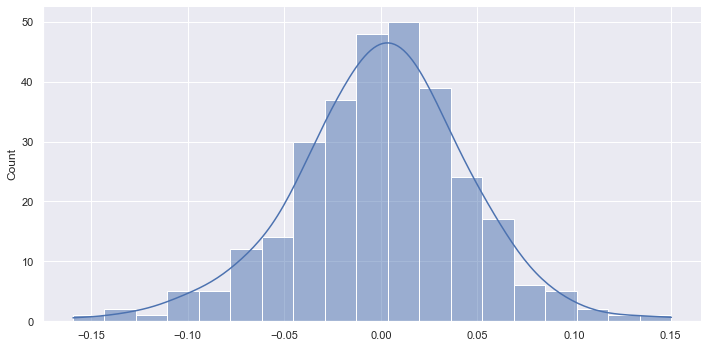

In [15]:
_g = sns.displot(
            x=fitted.resid,
            kind='hist',
            kde=True,
            aspect=2
)
plt.show()

### Forecasting

Plot forecasts for the next 12 months.

The merge is a *full outer join*[^4], given the indices of *all_ts_logdemand* and *_fcast* do not overlap.

We initialise a variable to hold reference to the forecasted values, which we use later on to plot the vertial line separating the *observed*, *fitted* lines from the *forecast* line.

If you think the separator is unnecessary, then *_fcast* is not needed and the forecast could be moved directly into the `merge` function.

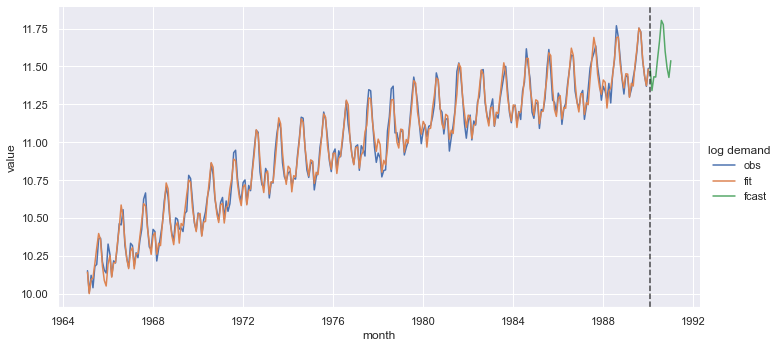

In [16]:
_fcast = fitted.forecast(12).rename('fcast')
_gsource = pd.merge(
    left=all_ts_logdemand,
    right=_fcast,
    how='outer',
    left_index=True,
    right_index=True
).rename_axis(
    'month',
    axis=0
).melt(
    var_name='log demand',
    ignore_index=False
).reset_index()

_g = sns.relplot(
            data=_gsource,
            x='month',
            y='value',
            hue='log demand',
            kind='line',
            aspect=2
)
plt.axvline(_fcast.index[0], alpha=0.7, ls='--', color='black')
plt.show()

Quantify a forecast.

In [17]:
_fcast = fitted.forecast(1)[0]
_std_err = np.sqrt(
    st.norm().ppf(0.975) * (fitted.sse / fitted.fittedvalues.size)
)
pd.Series(
    data=[_fcast, _fcast - _std_err,_fcast + _std_err],
    index= ['pred', 'lpb', 'upb']
)

pred    11.486707
lpb     11.423908
upb     11.549507
dtype: float64

[^1]: Arel-Bundock V (2022). Rdatasets: A collection of datasets originally distributed in various R packages. R package version 1.0.0, https://vincentarelbundock.github.io/Rdatasets
[^2]: See [The Datasets Package](https://www.statsmodels.org/devel/datasets/index.html)
[^3]: See [statsmodels.tsa.holtwinters.ExponentialSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)
[^4]: "*In theory, a **full outer join** is the combination of a left join and a right join. The full outer join includes all rows from the joined tables whether or not the other table has the matching row.*" ([sqltutorial.org](https://www.sqltutorial.org/sql-full-outer-join/))
[^5]: See [statsmodels.tsa.holtwinters.HoltWintersResults](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.HoltWintersResults.html)